# Introduction
This is my first time creating a kernel notebook. Please feel free to comment or make suggestions on improvements, especially with feature engineering. Thanks!

In creating this Kernel I referenced a number of other helpful Kernels and worked through the below suggested tutorials: 
* [DataCamp Python](https://www.datacamp.com/community/open-courses/kaggle-python-tutorial-on-machine-learning)
* [Kaggle Python tutorial](https://www.kaggle.com/c/titanic/details/getting-started-with-python)
* [Random forest benchmark r](https://www.kaggle.com/thamaliw/titanic/random-forest-benchmark-r)
* [Could the titanic have been saved](https://www.kaggle.com/daryadedik/titanic/could-the-titanic-have-been-saved)

## Load the data & import libraries

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from numpy.random import rand
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn import tree

# Load the train and test datasets to create two DataFrames
base_url = "./input"
train_url = base_url + "/train.csv"
train = pd.read_csv(train_url)

test_url = base_url + "/test.csv"
test = pd.read_csv(test_url)

# Combine test and training to facilitate cleanup and pre-processing
full_data = pd.concat([train, test], axis=0)

print ("Full data {}\n".format(full_data.shape))

# Lets see how we are doing with missing values
print("Full data missing \n{}\n".format(full_data.isnull().sum()))

Full data (1309, 12)

Full data missing 
Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64



## Cleaning the Data
### Simple imputations

In [2]:
# Remove Warnings from Pandas
pd.options.mode.chained_assignment = None  # default='warn'

# Lets fill the missing 'Embarked' values with the most occurred value, which is "S".
# 72.5% of people left from Southampton.
full_data.Embarked.fillna('S', inplace=True)

# There is only one missing 'Fare' and its in the test dataset
# Let's just go ahead and fill the fare value in with the median fare
full_data.Fare.fillna(full_data.Fare.median(), inplace=True)

# Lets take a look at Cabins...
# It looks like 77% and 78% of these fields are empty.
#But just going to map and see what happens

# Looking at the data it may be better to pull the Deck from the Cabin 
# but just statring here
#print("Null Cabins in training {:.4f}".format(1-(train["Cabin"].value_counts().sum()/ len(train["Cabin"]))))
#print("Null Cabins in test {:.4f}".format(1-(test["Cabin"].value_counts().sum()/len(test["Cabin"]))))
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"
    
    
full_data.Cabin = full_data.Cabin.apply(clean_cabin)
full_data = pd.concat([full_data, pd.get_dummies(full_data['Cabin'], prefix='Cabin')], axis=1)

      
# Also ignoring Ticket for now as it is not clear to me what to do with it.

### Normalize Data for use with Classification tools

In [3]:
# Create categories for Sex and Embarked
full_data = pd.concat([full_data, pd.get_dummies(full_data['Sex'], prefix='Sex')], axis=1)

full_data = pd.concat([full_data, pd.get_dummies(full_data['Embarked'], prefix='Embarked')], axis=1)

### Derive some new features from the Name field

In [4]:
# Extract the title from the name
def get_title(name):
    index_comma = name.index(',') + 2
    title = name[index_comma:]
    index_space = title.index('.') + 1
    title = title[0:index_space]
    return title

# Helper method to show unique_titles
unique_titles = {}
def get_unique_titles(name):
    title = get_title(name)
    if title in unique_titles:
        unique_titles[title] += 1
    else:
        unique_titles[title] = 1

# Uncomment to show the unique titles in the data set
#full_data["Name"].apply(get_unique_titles)
#print(unique_titles)

#Upon review of the unique titles we consolidate on the below mappings as optimal
def map_title(name):
    title = get_title(name)
    #should add no key found exception
    title_mapping = {"Mr.": 1, "Miss.": 2, "Ms.": 10, "Mrs.": 3, "Master.": 4, "Dr.": 5,
                     "Rev.": 6, "Major.": 7, "Col.": 7, "Don.": 7, "Sir.": 7, "Capt.": 7,
                     "Mlle.": 8, "Mme.": 8, "Dona.": 9, "Lady.": 9, "the Countess.": 9,
                     "Jonkheer.": 9}
    return title_mapping[title]


# Create a new field with a Title
full_data["Title"] = full_data["Name"].apply(map_title)

# Extract the last name from the title
def get_last_name(name):
    index_comma = name.index(',')
    last_name = name[0:index_comma:]
    #print(last_name)
    return last_name

# Helper method to show unique_last_names
unique_last_names = {}
def get_unique_last_names(name):
    last_name = get_last_name(name)
    if last_name in unique_last_names:
        unique_last_names[last_name] += 1
    else:
        unique_last_names[last_name] = 1


# Create a new field with last names
full_data["LastName"] = full_data["Name"].apply(get_last_name)

# Create a category by grouping like last names 
full_data["Name"].apply(get_unique_last_names)
full_data["LastNameCount"] = full_data["Name"].apply(lambda x: unique_last_names[get_last_name(x)])

### Impute missing ages using a couple of different techniques

In [5]:
# To set the missing ages we will find the median age for the persons title and use that
# as the age of the person
def map_missing_ages1(df):
    avg_title_age = {}
    # Find median age for all non null passengers
    avg_age_all= df['Age'].dropna().median()
    # Iterate all the titles and set a median age for each title
    for title in range(1,11):
        avg_age = df['Age'][(df["Title"] == title)].dropna().median()
         # If the average age is null for a title defualt back to average for all passengers
        if pd.isnull(avg_age):
            avg_age = avg_age_all
        avg_title_age[title] = avg_age

    # Now that we have a list with average age by title we apply it to all our null passengers
    # Map Ages without data
    for title in range(1,11):
        # print("title code:",title," avg age:",avg_title_age[title])
        df["Age"][(df["Title"] == title) & df["Age"].isnull()] = avg_title_age[title]


# Set the  missing ages by createing a classifier based on the below criteria
def map_missing_ages2(df):
    feature_list = [
                "Fare",
                "Pclass",
                "Parch",
                "SibSp",
                "Title",
                "Sex_female",
                "Sex_male",
                "Embarked_C",
                "Embarked_Q",
                "Embarked_S"
                ]

    etr = ExtraTreesRegressor(n_estimators=200,random_state = 42)

    train = df.loc[df.Age.notnull(),feature_list]
    target = df.loc[df.Age.notnull(),['Age']]

    test = df.loc[df.Age.isnull(),feature_list]
    etr.fit(train,np.ravel(target))

    age_preds = etr.predict(test)
    df.loc[df.Age.isnull(),['Age']] = age_preds

map_missing_ages2(full_data)

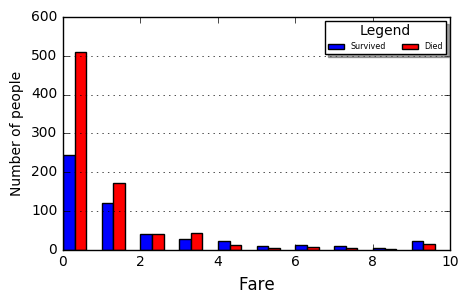

In [6]:
#Exploring some of the fare data looking for patterns
#create a Fare Category grouping fare prices

full_data["FareCat"]=0
r=0
for f in range(20,220,20):
    full_data["FareCat"][(full_data["Fare"] >= r) & (full_data["Fare"] < f)] = f
    #print("f >= {} & f < {}".format(r,f)) 
    r=f
    
full_data["FareCat"][(full_data["Fare"] >= 200)] = 200                        

#################################################
# Plot the Face Category
fig, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

survived = full_data['FareCat'][train['Survived']==1].value_counts().sort_index()
died =     full_data['FareCat'][train['Survived']==0].value_counts().sort_index()


width = 0.30
x_pos = np.arange(len(survived))

axis1.bar(x_pos, survived, width, color='b', label='Survived')
axis1.bar(x_pos + width, died, width, color='r', label='Died')
axis1.set_xlabel('Fare', fontsize=12)
axis1.set_ylabel('Number of people', fontsize=10)
axis1.legend(loc="upper right", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")
axis1.yaxis.grid(True)

plt.show()
##########################################################
    
#print(full_data["Fare"].round().value_counts().sort_index())
#www = full_data[(full_data["Fare"]==0.0)]
#www.loc[:,['Survived','Name','Sex','Age','Fare']]
#print(www)
#print("Full data missing \n{}\n".format(full_data.isnull().sum()))

## Visualization of key features
#### Evaluate features

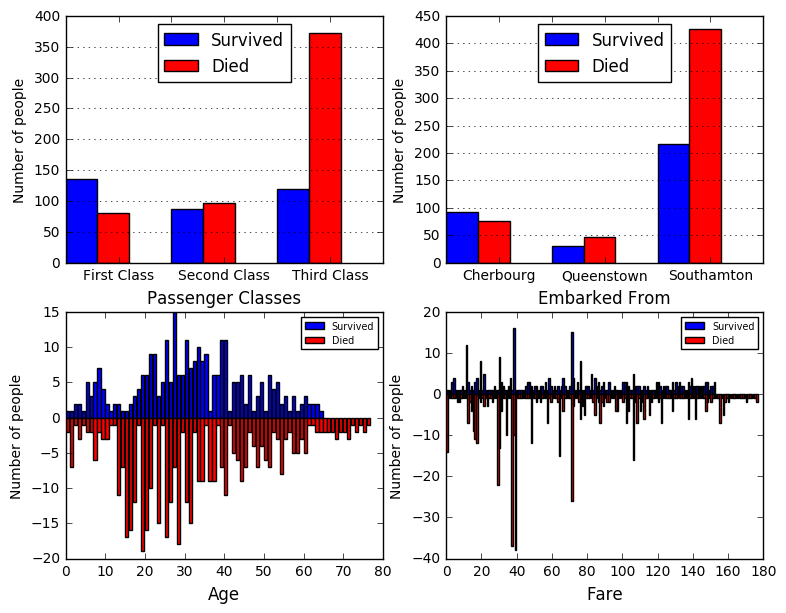

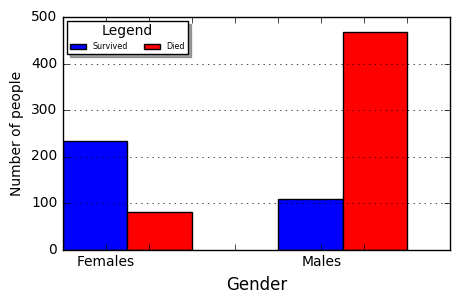

In [7]:
fig, ((axis1, axis2),(axis3, axis4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

###########################################################
pclass_survived = train['Pclass'][train['Survived']==1].value_counts().sort_index()
pclass_died =     train['Pclass'][train['Survived']==0].value_counts().sort_index()

width = 0.30
x_pos = np.arange(len(pclass_survived))

axis1.bar(x_pos,pclass_survived, width, color='blue', label='Survived')
axis1.bar(x_pos + width, pclass_died, width, color='red', label='Died')
axis1.set_xlabel('Passenger Classes', fontsize=12)
axis1.set_ylabel('Number of people', fontsize=10)
axis1.legend(loc='upper center')
axis1.set_xticklabels(('','First Class','','Second Class','','Third Class'))
axis1.yaxis.grid(True)

###########################################################
embarked_survived = train['Embarked'][train['Survived']==1].value_counts().sort_index()
embarked_died     = train['Embarked'][train['Survived']==0].value_counts().sort_index()

#print(embarked_died)
#print(embarked_survived)
x_pos = np.arange(len(embarked_survived))
axis2.bar(x_pos,embarked_survived, width, color='blue', label='Survived')
axis2.bar(x_pos + width, embarked_died, width, color='red', label='Died')
axis2.set_xlabel('Embarked From', fontsize=12)
axis2.set_ylabel('Number of people', fontsize=10)
axis2.legend(loc='upper center')
axis2.set_xticklabels(('','Cherbourg','','Queenstown','','Southamton'))
axis2.yaxis.grid(True)

###########################################################
# Age fill has an interesting spike based on the above fill of empty ages
age_survived = train['Age'][train['Survived']==1].value_counts().sort_index()
age_died     = train['Age'][train['Survived']==0].value_counts().sort_index()

minAge, maxAge = min(train.Age), max(train.Age)
bins = np.linspace(minAge, maxAge, 100)

# You can squash the distribution with a log function but I prefered to see the outliers
#axis3.bar(np.arange(len(age_survived)), np.log10(age_survived), color='blue', label='Survived')
#axis3.bar(np.arange(len(age_died)), -np.log10(age_died), color='red', label='Died')

axis3.bar(np.arange(len(age_survived)), age_survived, color='blue', label='Survived')
axis3.bar(np.arange(len(age_died)), -(age_died), color='red', label='Died')
#axis3.set_yticks(range(-3,4), (10**abs(k) for k in range(-3,4)))
axis3.legend(loc='upper right',fontsize="x-small")
axis3.set_xlabel('Age', fontsize=12)
axis3.set_ylabel('Number of people', fontsize=10)

###########################################################
# Chart Fare by Survived and Perished
fair_survived = train['Fare'][train['Survived']==1].value_counts().sort_index()
fair_died     = train['Fare'][train['Survived']==0].value_counts().sort_index()

minAge, maxAge = min(train.Age), max(train.Age)
bins = np.linspace(minAge, maxAge, 100)

axis4.bar(np.arange(len(fair_survived)), fair_survived, color='blue', label='Survived')
axis4.bar(np.arange(len(fair_died)), -(fair_died), color='red', label='Died')
#axis4.set_yticks(range(-3,4), (10**abs(k) for k in range(-3,4)))
axis4.legend(loc='upper right',fontsize="x-small")
axis4.set_xlabel('Fare', fontsize=12)
axis4.set_ylabel('Number of people', fontsize=10)

plt.show()

###########################################################
fig, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

survived = train['Sex'][train['Survived']==1].value_counts().sort_index()
died =     train['Sex'][train['Survived']==0].value_counts().sort_index()

width = 0.30
x_pos = np.arange(len(survived))

axis1.bar(x_pos, survived, width, color='b', label='Survived')
axis1.bar(x_pos + width, died, width, color='r', label='Died')
axis1.set_xlabel('Gender', fontsize=12)
axis1.set_ylabel('Number of people', fontsize=10)
axis1.set_xticklabels(('','Females','','','','','Males'))
axis1.legend(loc="upper left", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")
axis1.yaxis.grid(True)

plt.show()

## Create some new features
### New features

In [8]:
# Lets do some feature engineering

# Assign 1 to passengers under 14, 0 to those 14 or older.
full_data["Child"] = 0
full_data["Child"][full_data["Age"] < 14] = 1

# Create a Mother field (It seems Mother had a pretty high survival rate)
# Note that Title "Miss." = 2 in our mappings
full_data["Mother"] = 0
full_data["Mother"][(full_data["Parch"] > 0) & (full_data["Age"] > 18) &
                    (full_data["Sex"] == 'female') & (full_data["Title"] != 2)] = 1


full_data["FamilySize"] = full_data["SibSp"] + full_data["Parch"]

# Create a Family category none, small, large
full_data["FamilyCat"] = 0
full_data["FamilyCat"][ (full_data["Parch"] + full_data["SibSp"]) == 0] = 0
full_data["FamilyCat"][((full_data["Parch"] + full_data["SibSp"]) > 0) & ((full_data["Parch"] + full_data["SibSp"]) <= 3)] = 1
full_data["FamilyCat"][ (full_data["Parch"] + full_data["SibSp"]) > 3 ] = 2

full_data["SingleMale"] = 0 #0 -- Other ends up being females
full_data["SingleMale"][((full_data["Parch"] + full_data["SibSp"]) == 0) & (full_data["Sex"] == 'male')] = 2
full_data["SingleMale"][((full_data["Parch"] + full_data["SibSp"]) >  0) & (full_data["Sex"] == 'male')] = 1

full_data["AdultFemale"] = 0
full_data["AdultFemale"][(full_data["Age"] > 18) & (full_data["Sex"] == 'female')] = 1

full_data["AdultMale"] = 0
full_data["AdultMale"][(full_data["Age"] > 18) & (full_data["Sex"] == 'male')] = 1

full_data["PclassXAge"]= full_data["Pclass"] * full_data["Age"]
full_data["FareDivPclass"]= full_data["Fare"] / full_data["Pclass"]

import math

full_data["FareLog"] = full_data["Fare"].apply(lambda x: 0 if x == 0 else math.log2(x))
full_data["AgeLog"] = full_data["Age"].apply(lambda x: 0 if x == 0 else math.log2(x))
                                               

train_data = full_data.iloc[:891,:]
##########################################################
full_data["Class*MWC"]=0
# Return the likelyhood to survive based in class and gender
def survive_percentage_class(pclass,gender):
        if gender == 'child':
            x = train_data["Survived"][(train_data["Pclass"] == pclass) & (train_data["Child"] == 1 )]
        else:    
            x = train_data["Survived"][(train_data["Pclass"] == pclass) & (train_data["Sex"] == gender ) & (train_data["Child"] != 1 )]
        
        y = x.value_counts(normalize=True).sort_index()
        if len(y) >1:
            y = y[1]
        else:
            y = 1.0
        #print(int(round(y*100)) )
        return int(round(y*100)) 
    
# Iterate pclasses and gender and create new feature based on likelyhood to survive 
for gender in ['female','male','child']:
    #print("")
    for pclass in [1,2,3]:
        if gender == 'child':
            full_data["Class*MWC"][(full_data["Pclass"] == pclass) & 
                                   (full_data["Child"] == 1 )] = survive_percentage_class(pclass,gender)
        else:    
            full_data["Class*MWC"][(full_data["Pclass"] == pclass) & 
                                   (full_data["Sex"] == gender )] = survive_percentage_class(pclass,gender)

##########################################################
full_data["Fare*MWC"]=0
# Return the likelyhood to survive based on Fare and gender
def survive_percentage_fare(fare_cat,gender):
        if gender == 'child':
            x = train_data["Survived"][(train_data["FareCat"] == fare_cat) & (train_data["Child"] == 1 )]
        else:    
            x = train_data["Survived"][(train_data["FareCat"] == fare_cat) & (train_data["Sex"] == gender ) & (train_data["Child"] != 1 )]
        
        y = x.value_counts(normalize=True).sort_index()
        if len(y) >1:
            y = y[1]
        else:
            y = 1.0
        #print(int(round(y*100)) )
        return int(round(y*100)) 
    
# Iterate Fare category and gender and create new feature based on likelyhood to survive 
for gender in ['female','male','child']:
    #print("")
    for fare_cat in range(20,220,20):
        if gender == 'child':
            full_data["Fare*MWC"][(full_data["FareCat"] == fare_cat) & 
                                   (full_data["Child"] == 1 )] = survive_percentage_fare(fare_cat,gender)
        else:    
            full_data["Fare*MWC"][(full_data["FareCat"] == fare_cat) & 
                                   (full_data["Sex"] == gender )] = survive_percentage_fare(fare_cat,gender)

           
##########################################################
full_data["Compartment"]=0
# Return the likelyhood to survive based compartment
def survive_percentage_compartment(cat):
    x = train_data["Survived"][(train_data["Cabin"] == cat)]    
    y = x.value_counts(normalize=True).sort_index()
    if len(y) >1:
        y = y[1]
    else:
        y = 1.0
    print("cat:",cat,"y:\n",x.value_counts(normalize=True).sort_index())
    print("y:",int(round(y*100)) )
    return int(round(y*100)) 
    
# Iterate Fare category and gender and create new feature based on likelyhood to survive 
for compartment in ['A','B','C','D','E','F','G','T','N']:   
    full_data["Compartment"][(full_data["Cabin"] == compartment) ] = survive_percentage_compartment(compartment)


cat: A y:
 0.0    0.533333
1.0    0.466667
Name: Survived, dtype: float64
y: 47
cat: B y:
 0.0    0.255319
1.0    0.744681
Name: Survived, dtype: float64
y: 74
cat: C y:
 0.0    0.40678
1.0    0.59322
Name: Survived, dtype: float64
y: 59
cat: D y:
 0.0    0.242424
1.0    0.757576
Name: Survived, dtype: float64
y: 76
cat: E y:
 0.0    0.25
1.0    0.75
Name: Survived, dtype: float64
y: 75
cat: F y:
 0.0    0.384615
1.0    0.615385
Name: Survived, dtype: float64
y: 62
cat: G y:
 0.0    0.5
1.0    0.5
Name: Survived, dtype: float64
y: 50
cat: T y:
 0.0    1.0
Name: Survived, dtype: float64
y: 100
cat: N y:
 Series([], Name: Survived, dtype: float64)
y: 100


### Visualize our new features

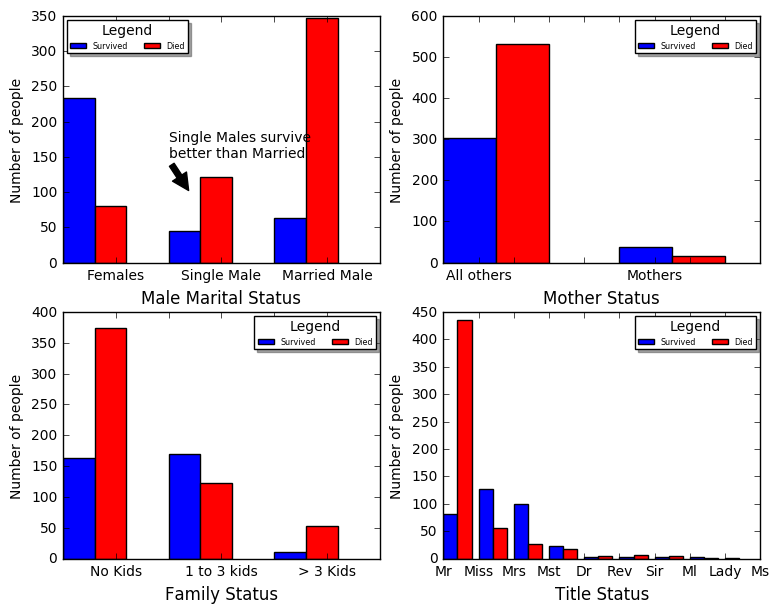

In [9]:
# Create some plots of our New Features
fig, ((axis1, axis2),(axis3, axis4)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
train = full_data.iloc[:891,:]

width = 0.30

###########################################################
single_male_survived = train['SingleMale'][train['Survived']==1].value_counts().sort_index()
single_male_died =     train['SingleMale'][train['Survived']==0].value_counts().sort_index()

x_pos = np.arange(len(single_male_survived))

axis1.bar(x_pos, single_male_survived, width, color='b', label='Survived')
axis1.bar(x_pos + width, single_male_died, width, color='r', label='Died')
axis1.set_xlabel('Male Marital Status', fontsize=12)
axis1.set_ylabel('Number of people', fontsize=10)
axis1.set_xticklabels(('','Females','','Single Male','','Married Male'))
axis1.legend(loc="upper left", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")

axis1.annotate('Single Males survive \nbetter than Married', xy=(1.2, 100),xytext=(1, 150),
              arrowprops=dict(facecolor='black', shrink=0.05),)

###########################################################
mother_survived = train['Mother'][train['Survived']==1].value_counts().sort_index()
mother_died =     train['Mother'][train['Survived']==0].value_counts().sort_index()
    
x_pos = np.arange(len(mother_survived))

axis2.bar(x_pos, mother_survived, width, color='b', label='Survived')
axis2.bar(x_pos + width, mother_died, width, color='r', label='Died')
axis2.set_xlabel('Mother Status', fontsize=12)
axis2.set_ylabel('Number of people', fontsize=10)
axis2.set_xticklabels(('','All others','','','','','Mothers'))
axis2.legend(loc="upper right", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")

###########################################################
family_survived = train['FamilyCat'][train['Survived']==1].value_counts().sort_index()
family_died =     train['FamilyCat'][train['Survived']==0].value_counts().sort_index()
    
x_pos = np.arange(len(family_survived))

axis3.bar(x_pos, family_survived, width, color='b', label='Survived')
axis3.bar(x_pos + width, family_died, width, color='r', label='Died')
axis3.set_xlabel('Family Status', fontsize=12)
axis3.set_ylabel('Number of people', fontsize=10)
axis3.set_xticklabels(('','No Kids','','1 to 3 kids','','> 3 Kids',''))
axis3.legend(loc="upper right", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")

###########################################################
title_survived = train['Title'][train['Survived']==1].value_counts().sort_index()
title_died =     train['Title'][train['Survived']==0].value_counts().sort_index()

width = 0.40
x_pos_s = np.arange(len(title_survived))
x_pos_d = np.arange(len(title_died))

axis4.bar(x_pos_s, title_survived, width, color='b', label='Survived')
axis4.bar(x_pos_d + width, title_died, width, color='r', label='Died')
axis4.set_xlabel('Title Status', fontsize=12)
axis4.set_ylabel('Number of people', fontsize=10)
axis4.set_xticklabels(('Mr','Miss','Mrs','Mst','Dr','Rev','Sir','Ml','Lady','Ms'))
axis4.legend(loc="upper right", fontsize="xx-small",
           ncol=2, shadow=True, title="Legend")

plt.show()

## Use Random Forest & Predict

In [26]:
# Setup calassifier and predict

def titanic_predict(feature_list, n_estimators, max_features, max_depth):

    train_all      = full_data.iloc[:891,:]
    train_features = train_all.loc[:,feature_list]
    train_target   = train_all.loc[:,['Survived']]
    test_data      = full_data.iloc[891:,:]
    test_features  = test_data.loc[:,feature_list]

    PassengerId =np.array(test["PassengerId"]).astype(int)
    

    #=============================
    # Building and fitting the Random forest
    #forest_classifier = RandomForestClassifier(max_depth = 6,
    #                                           min_samples_split=2,
    #                                           n_estimators = 450,
    #                                           random_state = 1)

    forest = RandomForestClassifier(n_estimators=n_estimators,
                                               max_features=max_features,
                                               max_depth=max_depth,
                                               #criterion='entropy',
                                               random_state=42)
    forest.fit(train_features, np.ravel(train_target))
    forest_pred = forest.predict(test_features)
    print("RandomForestClassifier score:",forest.score(train_features, train_target)) 
    #print(my_forest.feature_importances_)
    forest_solution = pd.DataFrame(forest_pred, PassengerId, columns = ["Survived"]).astype(int)
    forest_solution.to_csv("predict_random_forest.csv", index_label = ["PassengerId"])
    
    # Check that the data frame has 418 entries
    print(forest_solution.shape)
    return forest_solution, forest


feature_list = [
                "Age",
                "Fare",
                "Pclass",
                "Parch",
                "SibSp",
                "Sex_female",
                "Sex_male",
                "Embarked_C",
                "Embarked_Q",
                "Embarked_S",
                "Cabin_A",
                "Cabin_B",
                "Cabin_C",
                "PclassXAge",
                "FareDivPclass",
                "Cabin_D",
                "Cabin_E",
                "Cabin_F",
                "Cabin_G",
                "Cabin_None",
                "Cabin_T",
                "Class*MWC",
                "Compartment",
                "FareLog",
                "FareCat",
                "Fare*MWC",
                "AgeLog",
                "Title",
                "Mother",
                "FamilySize",
                "FamilyCat",
                "SingleMale",
                "AdultFemale",
                "AdultMale",
                "LastNameCount",
                "Child"
                ]

my_solution, my_forest = titanic_predict(feature_list,500,None,5)

RandomForestClassifier score: 0.875420875421
(418, 1)


In [11]:
# Try other classifiers
# None of the below produced results for me better than the Random Forest
# But I did not try to do much tuning
def other_classifiers(feature_list):
    train_all      = full_data.iloc[:891,:]
    train_features = train_all.loc[:,feature_list]
    train_target   = train_all.loc[:,['Survived']]
    test_data      = full_data.iloc[891:,:]
    test_features  = test_data.loc[:,feature_list]

    PassengerId =np.array(test["PassengerId"]).astype(int)

    #=============================
    # Logistic Regression
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(train_features, np.ravel(train_target))
    logreg_pred = logreg.predict(test_features)
    print("LogisticRegression score:",logreg.score(train_features, train_target))
    logreg_solution = pd.DataFrame(logreg_pred, PassengerId, columns = ["Survived"]).astype(int)
    logreg_solution.to_csv("predict_logistic_regression.csv", index_label = ["PassengerId"])
    #===============================

    #===============================
    # Gaussian Naive Bayes
    from sklearn.naive_bayes import GaussianNB
    gaussian = GaussianNB()
    gaussian.fit(train_features, np.ravel(train_target))
    gaussian_pred = gaussian.predict(test_features)
    print("GaussianNB score:",gaussian.score(train_features, train_target))
    gaussian_solution = pd.DataFrame(gaussian_pred, PassengerId, columns = ["Survived"]).astype(int)
    gaussian_solution.to_csv("predict_gaussian_nb.csv", index_label = ["PassengerId"])
    #===============================
    
    #===============================
    # K Neighbors
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(train_features, np.ravel(train_target))
    knn_pred = knn.predict(test_features)
    print("KNeighborsClassifier score:",knn.score(train_features, train_target))
    knn_solution = pd.DataFrame(knn_pred, PassengerId, columns = ["Survived"]).astype(int)
    knn_solution.to_csv("predict_k_neighbors.csv", index_label = ["PassengerId"])
    #===============================
    
    #===============================
    # Support Vector Machines
    from sklearn.svm import SVC
    svc = SVC()
    best_params = {'gamma': 0.015625, 'C': 8192.0, 'kernel': 'rbf'}
    print(best_params)
    svc.set_params(**best_params)
    svc.verbose=True 
    svc.fit(train_features, np.ravel(train_target))
    svc_pred = svc.predict(test_features)
    print("SupportVectorMachine score:",svc.score(train_features, train_target))
    svc_solution = pd.DataFrame(svc_pred, PassengerId, columns = ["Survived"]).astype(int)
    svc_solution.to_csv("predict_support_vector_machine.csv", index_label = ["PassengerId"])
    #===============================
    
    #import xgboost as xgb
    # Requires additional installation
    # not jus pip install


#Un comment to try other classifiers
#other_classifiers(feature_list)

/Users/danhiggins/.pyenv/versions/3.5.1/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


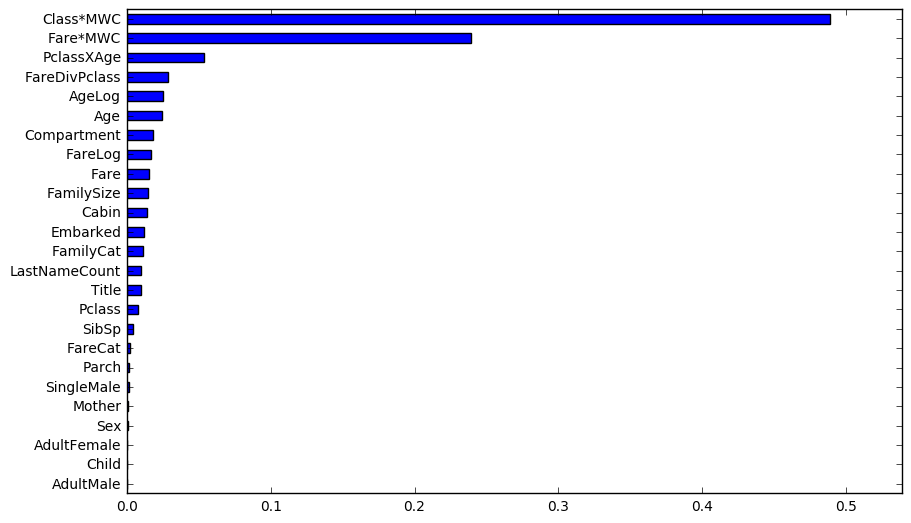

In [27]:
#Graph the importance of the features that have been created.
#Note: Use the categorical_variables variable to aggragate split categorier

def graph_feature_importance(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):

    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1

    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value=0.0
            for i, x in feature_dict.items():
                if col_name in i:
                    sum_value += x
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)

            feature_dict[col_name] = sum_value
            
    import numpy as np
    
    #This line below was difficult to figure out!!
    fme = np.array(list(feature_dict.values())).flatten()
    results = pd.Series(fme, index=feature_dict.keys())
    results.sort()
    results.plot(kind='barh', figsize=(width,len(results)/4), xlim=(0,x_scale))
    plt.show()

categorical_variables = ["Sex", "Cabin","Embarked"]
graph_feature_importance(my_forest,feature_list,summarized_columns=categorical_variables)

In [28]:
# Loop through different options of the Classifier
# Select the best also a good place to put cross validation test
import src.score_titanic_run as score

#n_estimator_options = [30,50,100,200,500,1000,2000]
n_estimator_options = [400,500,1000]
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2, 0.1]
max_features_options = [None]
#max_depth_options = [2,3,4,5,6,7,8,9,10]
max_depth_options = [5,6]
#max_depth_options = [None]
for n_estimators in n_estimator_options:
    for max_features in max_features_options:
        for max_depth in max_depth_options:
            titanic_predict(feature_list, n_estimators, max_features, max_depth)
            print("n_estimators=",n_estimators,"max_features=",max_features,"max_depth=",max_depth)
            score.run1()



RandomForestClassifier score: 0.876543209877
(418, 1)
n_estimators= 400 max_features= None max_depth= 5
Data! 		Correct		Wrong 
Results		327		91

RandomForestClassifier score: 0.897867564534
(418, 1)
n_estimators= 400 max_features= None max_depth= 6
Data! 		Correct		Wrong 
Results		332		86

RandomForestClassifier score: 0.875420875421
(418, 1)
n_estimators= 500 max_features= None max_depth= 5
Data! 		Correct		Wrong 
Results		328		90

RandomForestClassifier score: 0.897867564534
(418, 1)
n_estimators= 500 max_features= None max_depth= 6
Data! 		Correct		Wrong 
Results		333		85

RandomForestClassifier score: 0.87317620651
(418, 1)
n_estimators= 1000 max_features= None max_depth= 5
Data! 		Correct		Wrong 
Results		331		87

RandomForestClassifier score: 0.901234567901
(418, 1)
n_estimators= 1000 max_features= None max_depth= 6
Data! 		Correct		Wrong 
Results		333		85



In [14]:
# The below function helps to optimize your classifier
# allowing you to run a series of tests and see what parameters fit best. 
# Although I was excited when I found this the results I found where 
# not as good as the Manual process that I am applying above
#
def grid_search():    
    train_all      = full_data.iloc[:891,:]
    train_features = train_all.loc[:,feature_list]
    train_target   = train_all.loc[:,['Survived']]
    test_data      = full_data.iloc[891:,:]
    test_features  = test_data.loc[:,feature_list]

    PassengerId =np.array(test["PassengerId"]).astype(int)
    
    from sklearn.model_selection import GridSearchCV, StratifiedKFold
    n_folds = 10
    cv = StratifiedKFold(n_folds)
    N_es = [50, 100, 200, 400, 500]
    criteria = ['gini', 'entropy']
    #
    random_forest = RandomForestClassifier()
    gscv = GridSearchCV(estimator=random_forest, 
                        param_grid=dict(n_estimators=N_es, criterion=criteria), 
                        n_jobs=1, 
                        cv=list(cv.split(train_features, np.ravel(train_target))), 
                        verbose=2)
    gscv.fit(train_features, np.ravel(train_target))
    gscv_pred = gscv.predict(test_features)
    print("GridSearchCV score:",gscv.score(train_features, train_target)) 
    forest_solution = pd.DataFrame(gscv_pred, PassengerId, columns = ["Survived"]).astype(int)
    forest_solution.to_csv("predict_grid_search.csv", index_label = ["PassengerId"])
    
    
#grid_search()